<a href="https://colab.research.google.com/github/eldarhac/integral-superposition/blob/main/mechanistic_interpretability_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept Distillation with SAEs: Sports vs Non‑Sports (Gemma‑friendly)

This notebook is designed to run on modest GPUs (e.g., A100) by **dumping activations once** and then training/inspecting a **Sparse Autoencoder (SAE)** offline.
This notebook explores the feature-space of Gemma‑3 270M.

**Pipeline:**

1. Load a labeled dataset of news titles concepts (SPORTS vs NON‑SPORTS).

2. Dump hidden activations from a **single chosen layer** (bf16, batched, shards on disk).

3. Train a lightweight **SAE** on those activations (MSE + L1 sparsity).

4. Cluster similar latents in the dictionary using medoid, to rebuild more high-level concept mapping.

5. Inspect latents: top‑activating examples, distilled concept enrichment enrichment, sparsity, dead features.

6. Causal interventions via forward hooks to **ablate/patch** latents at that layer.

7. Visualize activation patterns of most distinctly active latents for distilled concept (SPORTS), and examine how their inner-concept definition.

### Import integral-superposition library

In [1]:
import os

# Clone the repository (if not already done)
!git clone https://github.com/eldarhac/integral-superposition.git

# Change to the project directory
os.chdir('/content/integral-superposition')

# Verify we're in the right place
!pwd
!ls pyproject.toml

# Install the package
!pip install -e .

# Optional: Install with Kaggle support
!pip install -e ".[kaggle]"

Cloning into 'integral-superposition'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 72 (delta 4), reused 72 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (72/72), 55.83 KiB | 1.80 MiB/s, done.
Resolving deltas: 100% (4/4), done.
/content/integral-superposition
pyproject.toml
Obtaining file:///content/integral-superposition
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for integral-superposition (pyproject.toml) ... done
  Created wheel for integral-superposition: filename=integral_superposition-0.1.0-0.editable-py3-none-any.whl size=7040 sha256=e1a770f2f16b4c2d8f2f70b37bfd580a817871436abeeccdd8c135c9699f2234
  Stored in directory: /tmp/pip-ephem-wheel-cache-38ovgd3h/wheels/a4/59/06/c1243d9635

### Use HF Token to connect notebook

In [2]:
from huggingface_hub import hf_hub_download, notebook_login
notebook_login()

### Load causal lanuage model

In [3]:
from integral_superposition import backends

# Load model
backend = backends.HFCausalLM.from_pretrained("google/gemma-3-270m")

config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.69M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/35.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/536M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/133 [00:00<?, ?B/s]

### Load Dataset

In [4]:
import pandas as pd
import kagglehub

TEXT_COLUMN = "title"
LABEL_COLUMN = "topic"

DATASET_CSV = os.path.join(kagglehub.dataset_download("kotartemiy/topic-labeled-news-dataset"), 'labelled_newscatcher_dataset.csv')

df = pd.read_csv(DATASET_CSV, sep=";")
assert TEXT_COLUMN in df.columns and LABEL_COLUMN in df.columns, f"Columns {TEXT_COLUMN},{LABEL_COLUMN} missing from CSV."
df = df[[TEXT_COLUMN, LABEL_COLUMN]].dropna().reset_index(drop=True)
df_positive = df[df[LABEL_COLUMN] == 'SPORTS']
df_negative = (df[df[LABEL_COLUMN] != 'SPORTS']).sample(len(df_positive))
# Normalize labels to {0,1}

# If labels are strings/objects, overwrite with numeric
if df_positive[LABEL_COLUMN].dtype == object:
    df_positive[LABEL_COLUMN] = 1
if df_negative[LABEL_COLUMN].dtype == object:
    df_negative[LABEL_COLUMN] = 0

# Concatenate and ensure int dtype
df = pd.concat([df_positive, df_negative], ignore_index=True)
df[LABEL_COLUMN] = df[LABEL_COLUMN].astype(int)

# Shuffle the rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(df.head())
print("Label balance:", df[LABEL_COLUMN].value_counts().to_dict())

100%|██████████| 9.45M/9.45M [00:00<00:00, 195MB/s]

Extracting files...


                                               title  topic
0  England fullback Danny Rose 'sick of cops aski...      1
1  44 years after, Makinde gives facelift to Leka...      0
2  Police find tonne of suspected cocaine after t...      0
3  Amazon rainforest fires: 10,000 infernos ragin...      0
4  Dolphins stock up, stock down: Who stood out o...      1
Label balance: {1: 15000, 0: 15000}


/tmp/ipython-input-2776731928.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positive[LABEL_COLUMN] = 1


### Dump activations from language model (layer 13)

In [5]:
from integral_superposition import (
    DumpConfig, Paths, dump
)

cfg = DumpConfig(
    layer=13,
    max_len=32,
    batch_size=64,
    dtype="bf16"
)

paths = Paths(
    shards_dir="acts_shards",
    sae_path="sae_weights.pt",
    summary_csv="latent_summary.csv"
)


print("Label distribution:", df["topic"].value_counts().to_dict())

# Dump activations
print(f"Dumping activations from layer {cfg.layer}...")
os.makedirs(paths.shards_dir, exist_ok=True)

dump.dump_layer_activations(
    df=df,
    text_col="title",
    label_col="topic",
    backend=backend,
    cfg=cfg,
    out_dir=paths.shards_dir
)

print("Activation dumping complete!")
print(f"Shards saved to: {paths.shards_dir}")



Label distribution: {1: 15000, 0: 15000}
Dumping activations from layer 13...


Dumping activations:   0%|          | 0/469 [00:00<?, ?it/s]

Total tokens dumped: 501379 | shards in acts_shards
Activation dumping complete!
Shards saved to: acts_shards


### Train SAE

In [6]:
import torch
from integral_superposition import (
    SAEConfig, Paths,
    sae, backends, dump
)


# Configuration
cfg = SAEConfig(
    k=2048,
    lr=3e-4,
    l1=1e-3,
    epochs=2,
    batch_size=4096
)

paths = Paths(
    shards_dir="acts_shards",
    sae_path="sae_weights.pt",
    summary_csv="latent_summary.csv"
)

# Check if activation shards exist
act_files = backends.io_store.shard_paths(paths.shards_dir, "acts")
if not act_files:
  print(f"No activation shards found in {paths.shards_dir}")
  print("Run 01_dump_activations.py first")

else:
  print(f"Found {len(act_files)} activation shards")

  # Get model dimensions from first shard
  sample_acts = backends.io_store.load_npy(act_files[0], mmap=True)
  d_model = sample_acts.shape[1]
  print(f"d_model: {d_model}, k_latents: {cfg.k}")

  # Create SAE model
  model = sae.SparseAutoencoder(d_model, cfg.k)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Training on device: {device}")

  # Create data iterator
  def shard_iterator():
      """Iterator over activation shards."""
      return dump.stream_shards(act_files, batch=cfg.batch_size)

  # Train SAE
  print("Training SAE...")
  sae.train_sae(
      sae=model,
      shard_iter=shard_iterator,
      cfg=cfg,
      device=device
  )

  # Save trained model
  print(f"Saving SAE to {paths.sae_path}")
  sae.save_sae(model, paths.sae_path)

  print("SAE training complete!")

Found 469 activation shards
d_model: 640, k_latents: 2048
Training on device: cuda
Training SAE...


SAE epoch 1/2: 0it [00:00, ?it/s]

  recon MSE: 69497.806224 | L1(z): 316.143974 | lam=0.001


SAE epoch 2/2: 0it [00:00, ?it/s]

  recon MSE: 520.654971 | L1(z): 396.649912 | lam=0.001
Saving SAE to sae_weights.pt
SAE training complete!


In [8]:
import numpy as np
from integral_superposition import (
    # Paths, sae, backends,
    analysis
)

print(f"SAE loaded: {model.d_model} -> {model.k}")

# Get shard files
act_files = backends.io_store.shard_paths(paths.shards_dir, "acts")
lab_files = backends.io_store.shard_paths(paths.shards_dir, "labels")

if not act_files or not lab_files:
  print("Activation or label shards not found")

else:
  print(f"Found {len(act_files)} shards")

  # Build global labels array
  print("Building global labels array...")
  offsets = [0]
  labels_parts = []

  for lf in lab_files:
      labels_shard = backends.io_store.load_npy(lf, mmap=True).astype(np.int64)
      labels_parts.append(labels_shard)
      offsets.append(offsets[-1] + len(labels_shard))

  labels_global = np.concatenate(labels_parts)
  print(f"Total tokens: {len(labels_global)}")
  print("Label distribution:", dict(zip(*np.unique(labels_global, return_counts=True))))

  # Compute top-k token sets per latent
  print("Computing top-k activating tokens per latent...")
  top_k_sets = analysis.top_tokens.topk_sets_per_latent(
      sae=model,
      act_files=act_files,
      device=device,
      k=200
  )

  # Convert to dict for enrichment analysis
  top_idx_dict = {j: np.array(list(token_set), dtype=np.int64)
                  for j, token_set in enumerate(top_k_sets)}

  # Compute enrichment statistics
  print("Computing enrichment statistics...")
  summary_df = analysis.enrichment.fisher_enrichment(top_idx_dict, labels_global)

  # Save summary
  summary_df.to_csv(paths.summary_csv, index=False)
  print(f"Summary saved to {paths.summary_csv}")

  # Show top results
  print("\nTop 10 most enriched latents:")
  print(summary_df.head(10)[['latent', 'topK_count', 'sports_frac_topK',
                              'odds_ratio', 'fisher_p']])

  # Basic statistics
  active_latents = (summary_df['topK_count'] > 0).sum()
  print(f"\nActive latents: {active_latents}/{len(summary_df)}")
  print(f"Mean activations per latent: {summary_df['topK_count'].mean():.1f}")

  print("Latent analysis complete!")


SAE loaded: 640 -> 2048
Found 469 shards
Building global labels array...
Total tokens: 501379
Label distribution: {np.int64(0): np.int64(249992), np.int64(1): np.int64(251387)}
Computing top-k activating tokens per latent...


Processing shards:   0%|          | 0/469 [00:00<?, ?it/s]

Computing enrichment statistics...
Summary saved to latent_summary.csv

Top 10 most enriched latents:
      latent  topK_count  sports_frac_topK  odds_ratio      fisher_p
432      432         200               1.0         inf  1.385260e-60
588      588         200               1.0         inf  1.385260e-60
611      611         200               1.0         inf  1.385260e-60
774      774         200               1.0         inf  1.385260e-60
935      935         200               1.0         inf  1.385260e-60
992      992         200               1.0         inf  1.385260e-60
1118    1118         200               1.0         inf  1.385260e-60
1166    1166         200               1.0         inf  1.385260e-60
1176    1176         200               1.0         inf  1.385260e-60
1263    1263         200               1.0         inf  1.385260e-60

Active latents: 2048/2048
Mean activations per latent: 199.0
Latent analysis complete!


### Clustering similar latents and refit decoder

In [11]:
from integral_superposition import (
    # Paths, sae, backends, analysis
    merge
)

K = model.k
d_model = model.d_model
print(f"Original SAE: {d_model} -> {K}")

# Get decoder weights for clustering
W = model.dec.weight.detach().cpu().numpy()  # [d_model, K]

# Compute cosine distance matrix
print("Computing cosine distances...")
cosine_dist = merge.cluster.cosine_dist_from_decoder(W)

# Determine number of clusters
n_clusters = merge.cluster.auto_n_clusters(K, target_compression=0.125)
print(f"Clustering {K} latents into {n_clusters} groups")

# Perform clustering
labels = merge.cluster.agglomerative_labels(cosine_dist, n_clusters)

# Find medoids
medoids = merge.medoid.medoids_from_labels(cosine_dist, labels)
print(f"Selected {len(medoids)} medoids")

# Create merge matrix
M = merge.medoid.merge_matrix_from_labels(labels, medoids)
print(f"Merge matrix shape: {M.shape}")

# Print clustering statistics
cluster_stats = merge.medoid.cluster_stats(labels)
print("Clustering stats:", cluster_stats)


# Create data iterator for refitting
def activation_iterator():
    """Iterator over activation data."""
    for batch in dump.stream_shards(act_files, batch=4096):
        if batch.shape[0] > 0:
            yield batch

# Refit decoder
print("Refitting decoder weights...")
W_new = merge.refit.merge_and_refit_decoder(
    X_iter=activation_iterator,
    sae=model,
    M=M,
    l2=1e-3,
    device=str(device)
)

print(f"New decoder shape: {W_new.shape}")
print(f"Compression ratio: {W_new.shape[1] / K:.3f}")

# Create new SAE with merged decoder
merged_sae = sae.SparseAutoencoder(d_model, len(medoids))

# Copy encoder weights (will map to old latent space)
merged_sae.enc.weight.data = model.enc.weight.data.clone()
merged_sae.enc.bias.data = model.enc.bias.data.clone()

# Set new decoder weights
merged_sae.dec.weight.data = torch.from_numpy(W_new.T)  # [K', d_model]

# Save merged model
merged_path = paths.sae_path.replace('.pt', '_merged.pt')
sae.save_sae(merged_sae, merged_path)
print(f"Merged SAE saved to {merged_path}")

# Save merge matrix
merge_matrix_path = "merge_matrix.npy"
np.save(merge_matrix_path, M)
print(f"Merge matrix saved to {merge_matrix_path}")

print("Merge and refit complete!")


Original SAE: 640 -> 2048
Computing cosine distances...
Clustering 2048 latents into 256 groups
Selected 256 medoids
Merge matrix shape: (2048, 256)
Clustering stats: {'n_clusters': 256, 'mean_cluster_size': 8.0, 'max_cluster_size': 18, 'min_cluster_size': 4, 'compression_ratio': 0.125}
Refitting decoder weights...
New decoder shape: (640, 256)
Compression ratio: 0.125
Merged SAE saved to sae_weights_merged.pt
Merge matrix saved to merge_matrix.npy
Merge and refit complete!


## Visualizations:

### Create 2D visualizations of latent space.

Collected 1280 titles
Label distribution: {np.int64(0): np.int64(631), np.int64(1): np.int64(649)}
Fitting 2D reducer...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Creating titles map...


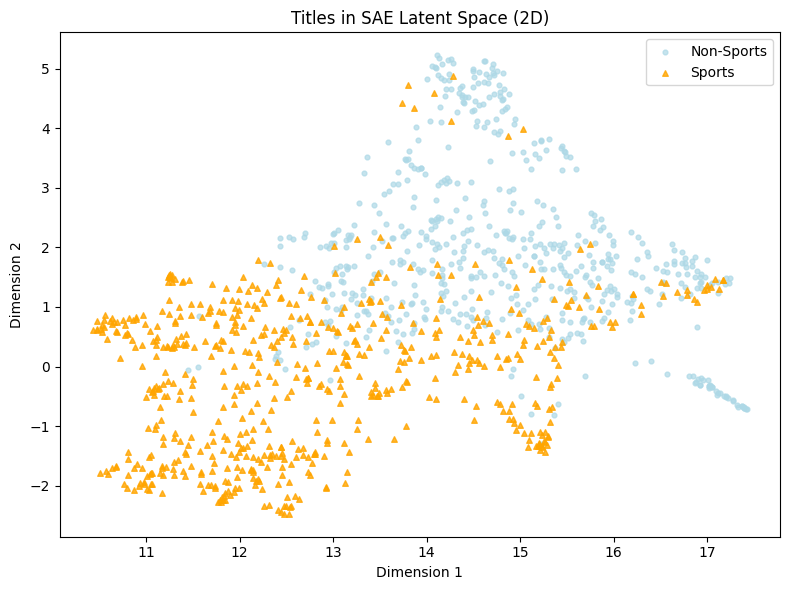

In [149]:
from integral_superposition import viz


# Collect title-level latent codes (mean-pooled)
per_title_zsum = {}
per_title_counts = {}
per_title_labels = {}

with torch.no_grad():
    for af, lf, tf in zip(act_files[:20], lab_files[:20], ttl_files[:20]):  # Limit for demo
        acts = backends.io_store.load_npy(af, mmap=True)
        labs = backends.io_store.load_npy(lf, mmap=True).astype(np.int64)
        ttls = backends.io_store.load_npy(tf, mmap=True).astype(np.int64)

        # Process in batches
        batch_size = 2048
        for start in range(0, acts.shape[0], batch_size):
            end = min(start + batch_size, acts.shape[0])
            x_batch = torch.from_numpy(acts[start:end].astype(np.float32)).to(device)

            z = model.encode(x_batch).cpu().numpy()

            for i in range(z.shape[0]):
                title_id = int(ttls[start + i])
                label = int(labs[start + i])

                if title_id not in per_title_zsum:
                    per_title_zsum[title_id] = z[i]
                    per_title_counts[title_id] = 1
                    per_title_labels[title_id] = label
                else:
                    per_title_zsum[title_id] += z[i]
                    per_title_counts[title_id] += 1

# Mean pool and create arrays
title_ids = sorted(per_title_zsum.keys())
Z_titles = np.stack([per_title_zsum[tid] / per_title_counts[tid] for tid in title_ids])
y_titles = np.array([per_title_labels[tid] for tid in title_ids])

print(f"Collected {len(title_ids)} titles")
print("Label distribution:", dict(zip(*np.unique(y_titles, return_counts=True))))

# Create 2D reducer
print("Fitting 2D reducer...")
reducer = analysis.reducer.create_reducer("umap", n_components=2, random_state=42, n_neighbors=25, min_dist=0.1, metric="cosine")
reducer.fit(Z_titles)

# Plot titles map
print("Creating titles map...")
viz.maps.titles_map(Z_titles, y_titles, reducer, trim_p=95.0)

#### Optional: plot top "SPORTS" sample medoids

Loading latent summary...
Creating medoids map...


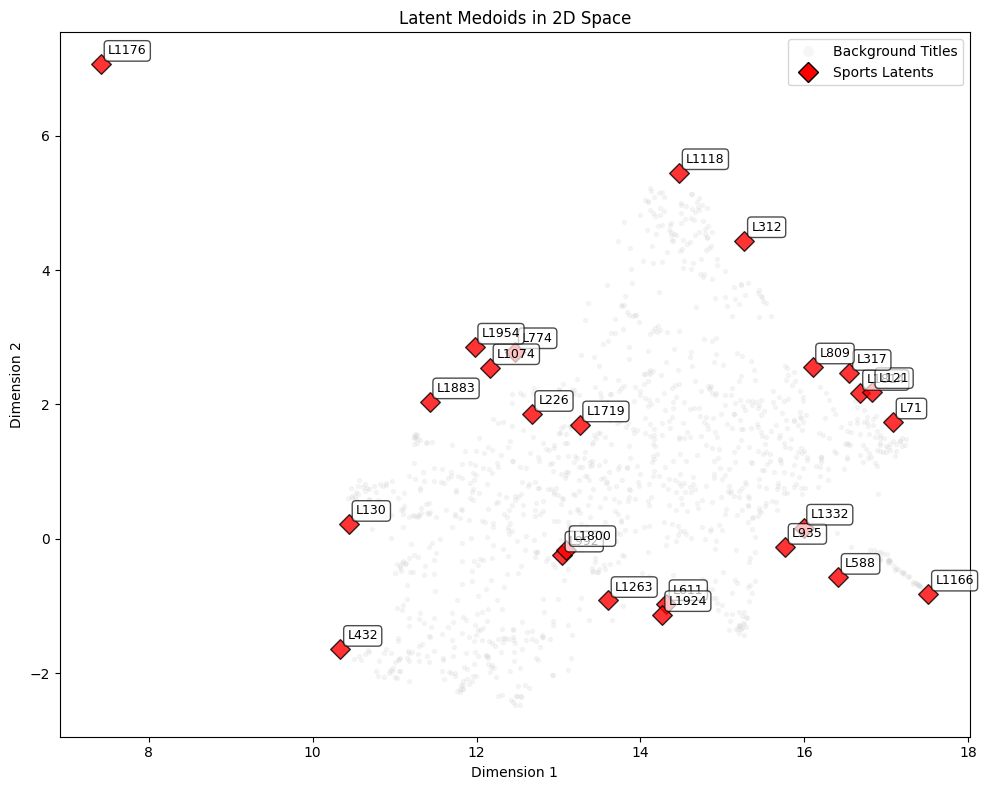

In [158]:
# Load summary for medoid analysis
if os.path.exists(paths.summary_csv):
    print("Loading latent summary...")
    summary = pd.read_csv(paths.summary_csv)

    # Get top sports-enriched latents as "medoids"
    top_latents = summary.head(25)
    medoids = top_latents['latent'].values

    # Create labels for medoids
    labels_text = [f"L{int(lat)}" for lat in medoids]
    is_sport = (top_latents['sports_frac_topK'] > 0.5).values

    print("Creating medoids map...")
    viz.maps.latents_labels_map(
        reducer=reducer,
        Z_titles=Z_titles,
        medoids=medoids,
        labels_text=labels_text,
        is_sport=is_sport
    )

### Causal interventions via forward hooks

#### Imports + helper function

In [121]:
import torch
import pandas as pd
from integral_superposition import steering
import transformers
transformers.utils.logging.set_verbosity_error()

layer_idx = 13  # Should match dump configuration
sports_latents = summary.head(12)['latent'].tolist()



def generate_with_steering(prompt: str, latents: list, intervention: float, iterations=10):
    """Generate text with latent steering."""

    # Create latent modification function
    latent_modifier = steering.hooks.multi_latent_modifier(
        latent_indices=latents,
        set_to=intervention
    )

    # Register steering hook
    handle = steering.register_prehook_last_row(
        backend=backend,
        layer_idx=layer_idx,
        sae=model,
        latent_map=latent_modifier
    )

    try:
        generated = prompt

        # Tokenize prompt
        for i in range(iterations):
          inputs = backend.tokenize([generated], max_len=32)
          inputs = {k: v.to(backend.device) for k, v in inputs.items()}

          # Generate
          with torch.no_grad():
              outputs = backend.generate(
                  **inputs,
                  max_new_tokens=1,
                  do_sample=False,
                  pad_token_id=backend.tokenizer.eos_token_id
              )

          # Decode

          generated = backend.tokenizer.decode(outputs[0], skip_special_tokens=True)
        return generated

    finally:
        handle.remove()

#### Testing some steering scenarios

In [122]:
# Test prompts
test_prompts = [
    "Manchester",
    "The 2022 world",
    "The national",
    "Barcelona the only"
]

# Test different intervention strengths
print("\n=== STEERING EXPERIMENTS ===")

for prompt in test_prompts:
    print(f"\nPrompt: '{prompt}'")

    # Baseline (no intervention)
    baseline = generate_with_steering(prompt, sports_latents, 0.0)
    print(f"Baseline:     {baseline}")

    # Suppress sports (negative intervention)
    suppressed = generate_with_steering(prompt, sports_latents, -600.0)
    print(f"Suppressed:   {suppressed}")

    # Enhance sports (positive intervention)
    enhanced = generate_with_steering(prompt, sports_latents, 600.0)
    print(f"Enhanced:     {enhanced}")


=== STEERING EXPERIMENTS ===

Prompt: 'Manchester'
Baseline:     Manchester is a city that is a melting-pot of
Suppressed:   Manchester is from play please please please please please please please
Enhanced:     Manchester United have been left in a difficult position with the

Prompt: 'The 2022 world'
Baseline:     The 2022 world’s best man is a very important prize in
Suppressed:   The 2022 worldpotcgoc #potcu #pothi
Enhanced:     The 2022 world cup is here and the Qatar World Cup is just

Prompt: 'The national'
Baseline:     The national exhibition of 1000-10
Suppressed:   The nationalotcgoavercgoaveroavero
Enhanced:     The national team of the country of the same name, which

Prompt: 'Barcelona the only'
Baseline:     Barcelona the only city in the world that is a haven for the
Suppressed:   Barcelona the only chance to highlight numberbbgobbgobboll
Enhanced:     Barcelona the only team in the world to have won the Champions League


### Top Activation Visualziations

#### Relevant imports

In [99]:
from integral_superposition.viz import top_activations_panel
tok_files = [f.replace("_acts.npy","_tokids.npy") for f in act_files]

Will can visualize the top activations for some of our candidate latents to see how they fires on *sports*-related subjects

### PGA Tour (Golf) Latent:

In [94]:
top_activations_panel(sports_latents[3], act_files, tok_files, model, backend.tokenizer, device)

###  European Football (Soccer) Latent

In [97]:
# Usage:
top_activations_panel(sports_latents[6], act_files, tok_files, model, backend.tokenizer, device)

### NBA Latent:

In [93]:
top_activations_panel(sports_latents[8], act_files, tok_files, model, backend.tokenizer, device)

### National Hockey League (NHL) Latent:

In [109]:
top_activations_panel(sports_latents[10], act_files, tok_files, model, backend.tokenizer, device)

### Championships and Playoffs Latent:

In [102]:
top_activations_panel(sports_latents[9], act_files, tok_files, model, backend.tokenizer, device)

### "Match" Latent:

In [108]:
top_activations_panel(sports_latents[7], act_files, tok_files, model, backend.tokenizer, device)

© All rights reserved to Eldar Hacohen, free to use for research purposes with credit.